In [2]:
import sqlite3
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Part 1: Wrangling

# Problem 1
# Connect to the sqlite file
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Calculate total payroll for each year for each team
salary_query = "SELECT yearID, sum(salary) as total_payroll, teamID FROM Salaries GROUP BY teamID, yearID"
team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

# Calculate winning percentage for each year for each team
win_query = "SELECT yearID, (CAST( W as float)/G)*100 as winning_percentage, W, G, teamID FROM Teams GROUP BY teamID, yearID"
team_wins = pd.read_sql(win_query, conn)
team_wins.head()

# Create a table displaying total team payroll alongside percentage of games won each year 
tbl = team_salaries.merge(team_wins, how = "left", left_on=["teamID", "yearID"], right_on=["teamID", "yearID"])
tbl

,yearID,total_payroll,teamID,winning_percentage,W,G
0,1985,14807000.0,ATL,40.740741,66.0,162.0
1,1985,11560712.0,BAL,51.552795,83.0,161.0
2,1985,10897560.0,BOS,49.693252,81.0,163.0
3,1985,14427894.0,CAL,55.555556,90.0,162.0
4,1985,9846178.0,CHA,52.147239,85.0,163.0
...,...,...,...,...,...,...
855,2014,120693000.0,SLN,55.555556,90.0,162.0
856,2014,72689100.0,TBA,47.530864,77.0,162.0
857,2014,112255059.0,TEX,41.358025,67.0,162.0
858,2014,109920100.0,TOR,51.234568,83.0,162.0


For this problem I connected to the sqlite database. Then, I sent an SQL query to access team salaries for each year and sum them together to calculate total payroll. I also sent an SQL query to access number of wins for each team as well as number of games played in total for each team. Then, I calculated win percentage from that data. Finally, I displayed all the data alongside each other by creating a table that displays year, total payroll, team ID, win percentage, number of games won, and total games played for each team in each year. 

<AxesSubplot:xlabel='yearID', ylabel='total_payroll'>

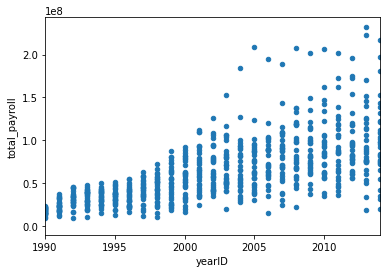

In [4]:
# Part 2: Exploratory Data Analysis

# Problem 2
# Create a scatter plot that displays total team payrolls between the years 1990 and 2014, inclusive
tbl.plot.scatter(x = "yearID", y = "total_payroll", xlim = (1990, 2014))

For this problem, I used plot.scatter to create a scatter plot displaying total payroll for a team as a function of the year. I limited the years to 1990-2014 only. 

**QUESTION 1**: Over time, the maximum total payroll for a team has generally increased. In other words, the absolute highest amount a team has been payed in a given year generally increases every year. Some years experience dips in this amount, but it is generally increasing. Additionally, the spread of the payroll data also increases with time. The total payroll data for 2014 is highly varied while total payroll data for 1990 has extremely low variance.

Text(0, 0.5, 'Maximum Total Payroll')

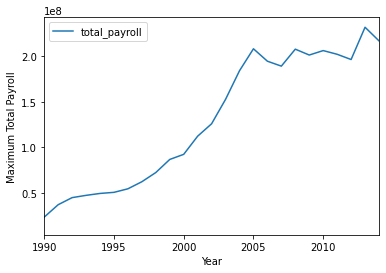

In [5]:
# Problem 3
# Plot the maximum team payroll for each calendar year between 1990 and 2014, inclusive 
payrollmax = team_salaries.groupby("yearID").max()
payrollmax["Year"] = payrollmax.index
plot = payrollmax.plot(x = "Year", y = "total_payroll", xlim = (1990, 2014))
plot.set_ylabel("Maximum Total Payroll")

For this problem, I grouped each team's total payrolls by year and found the maximum total payroll out of all of them. Then, I created a line graph using the plot function that plotted the maximum total payroll for each year. 
The above line graph plots the maximum team payroll for each year between 1990 and 2014, inclusive. The plot demonstrates how, in general, the highest team payroll steadily increases each year. Although there are fluctuations as X approaches 2014, the maximum team payroll generally increases over time. 

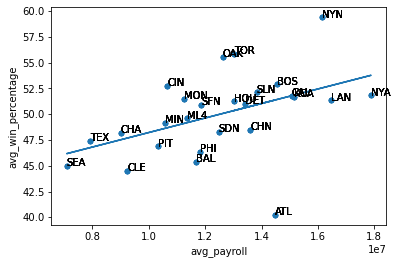

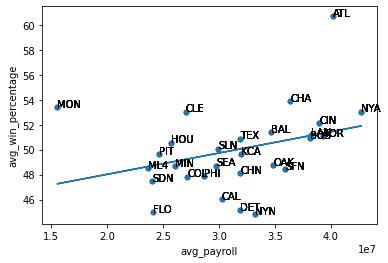

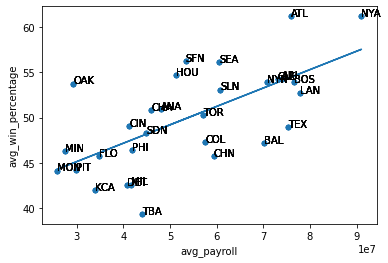

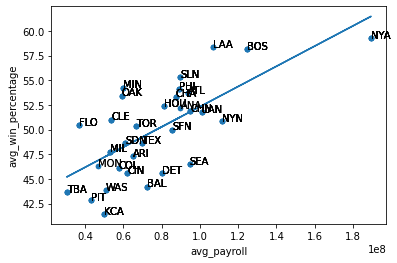

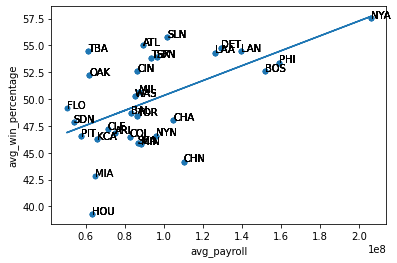

In [9]:
# Problem 4

# Discretize into 5 different time periods 
tbl.dropna(inplace=True)
discretize = pd.cut(tbl["yearID"], 5)
tbl["bins"] = discretize

# Get average payroll and win percentage 
tbl["avg_payroll"] = tbl.groupby(["bins", "teamID"])["total_payroll"].transform('mean')
tbl["avg_win_percentage"] = tbl.groupby(["bins","teamID"])["winning_percentage"].transform('mean')

# Split data into 5 sections by the bin value
binned = [x for _, x in tbl.groupby(tbl["bins"])]

# Create scatterplots for avg win percentage vs. avg payroll for each of the 5 time periods 
for curr in binned:
    curr.plot(x ='avg_payroll', y='avg_win_percentage', kind = 'scatter')
    
    for idx, row in curr.iterrows():
        plt.annotate(row['teamID'], (row['avg_payroll'], row['avg_win_percentage']))
    
    # Add trend line
    trend = np.polyfit(curr['avg_payroll'], curr['avg_win_percentage'], 1)
    trendpoly = np.poly1d(trend)
    
    plt.plot(curr['avg_payroll'],trendpoly(curr['avg_payroll']))

For this problem, I used the pandas cut function to discretize/split the data into 5 sections using the year as the bin value. Then, I created scatter plots for each section, annotating each point in the plot with the team ID and using the polyfit function to add a trend line to each plot.

**QUESTION 2**: Generally, the higher the average payroll for a team, the more likely they are to win a game (higher win percentage). The line of best fit proves that this is the relationship between average payroll and win percentage. Oakland A seems to have pretty good spending efficiency since they are pretty consistently above the line of best fit and they have a lower payroll for a higher percentage of wins. The only time period where this was not the case was from 1991 to 1996. In fact, OAK is the only team with a notably good spending efficency because it is the most consistently above the best fit line and in the upper left quadrant out of all the teams. 

In [7]:
# Problem 5

# Get standard deviation for team payrolls
tbl["std_dev"] = tbl.groupby(["bins", "teamID"])["total_payroll"].transform('std')

# Calculate standardized payroll and add to data 
sd_payroll = []
for i, row in tbl.iterrows():
    sd_payroll.append((row['total_payroll'] - row['avg_payroll'])/row['std_dev'])
    
tbl["sd_payroll"] = sd_payroll

For this problem, I calculate standard deviation for each team payroll, and then used that value and the average payroll to calculate standardized payroll for each team. Then, I added this value to the data. 

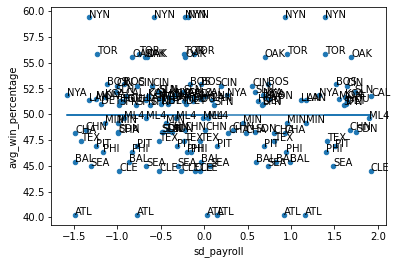

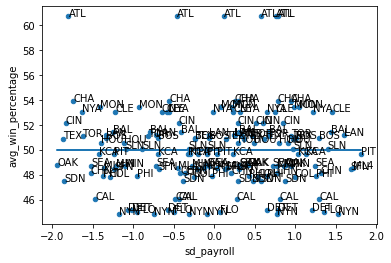

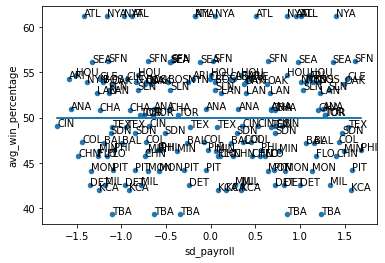

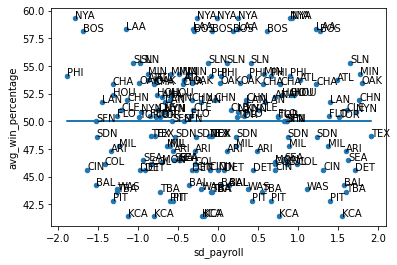

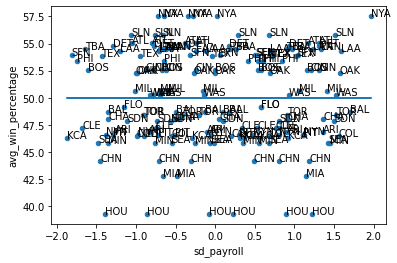

In [11]:
# Problem 6

# Create scatterplots for 5 different time periods, this time avg win percentage vs. standardized payroll
for curr in binned:
    curr.plot(x ='sd_payroll', y='avg_win_percentage', kind = 'scatter')
    for idx, row in curr.iterrows():
        plt.annotate(row['teamID'], (row['sd_payroll'], row['avg_win_percentage']))
        
    # Add trend line
    trend = np.polyfit(curr['sd_payroll'], curr['avg_win_percentage'], 1)
    trendpoly = np.poly1d(trend)
    
    plt.plot(curr['sd_payroll'],trendpoly(curr['sd_payroll']))

For this problem, I used the same method as Problem 4 to create a scatter plot but this time plotting average win percentage as a function of standardized payroll. I annotated each point with team ID and added a trend line to make it clear which teams have better spending efficiency and which have worse spending efficiency. 

**QUESTION 3**: The above plots display the distributions of how the teams were payed during each time interval. The standardized payroll reflects current pay relative to the mean pay, so the spending efficency is clearer than plots that use the average payroll. In Problem 4, the transformation on the payroll variable found the average payroll and in Problem 6, the transformation found the effect of the average on the payroll.

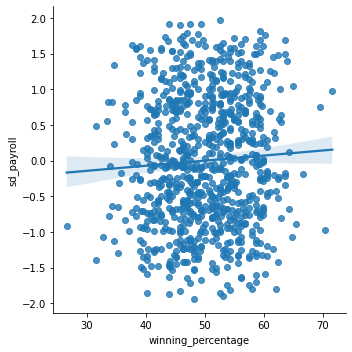

In [9]:
# Problem 7
import seaborn as sns

# Create scatterplot for win percentage vs. standardized payroll for all years, with regression line
sns.lmplot(x='winning_percentage', y='sd_payroll', data = tbl, fit_reg = True)
tbl['expected_win_pct'] = 50 + 2.5 * tbl['sd_payroll']

For this problem, I used seaborn lmplot function, which allows you to create a scatterplot with a regression line to portray the behavior of the data. I also calculated expected winning percentage using the formula given. 

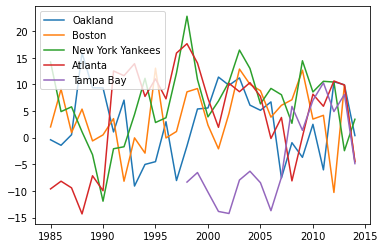

In [10]:
# Problem 8

# Calculate efficiency 
tbl['efficiency'] = tbl['winning_percentage'] - tbl['expected_win_pct']

# Create line plot for each team's efficiency 
oak = []
bos = []
nya = []
atl = []
tba = []
tba_year = []

year = tbl["yearID"].drop_duplicates()
for index, row in tbl.iterrows():
    if row["teamID"] == "OAK":
        oak.append(row["efficiency"])
    if row["teamID"] == "BOS":
        bos.append(row["efficiency"])
    if row["teamID"] == "NYA":
        nya.append(row["efficiency"])
    if row["teamID"] == "ATL":
        atl.append(row["efficiency"])
    if row["teamID"] == "TBA":
        tba_year.append(row["yearID"])
        tba.append(row["efficiency"])
        
plt.plot(year, oak, label = "Oakland")
plt.plot(year, bos, label = "Boston")
plt.plot(year, nya, label = "New York Yankees")
plt.plot(year, atl, label = "Atlanta")
plt.plot(tba_year, tba, label = "Tampa Bay")
plt.legend()
plt.show()

For this problem, I calculated spending efficiency for each team using the formula given. Then, I used the plot function to plot all five teams' spending efficiency as a function of the year in a single plot. 

**QUESTION 4**: This plot makes it easier to compare spending efficiencies between teams and between years. The different line graphs for each team superimposed on each other allows readers to learn a lot more about the spending efficiences of any given team compared to the other teams in any given year, compared to the plots in Questions 2 and 3. Oakland’s efficiency during the Moneyball period (2002) peaked over the other teams by a significant amount, meaning that they were very efficient with their spending at that time.